# Separating Stars and Galaxies from SDSS 

##### Version 0.1

***
By AA Miller 2018 Feb 21

**Getting started**

Python boundary coniditions: before you begin work on this notebook, you will need to install a few non-standard `python` packages (note - I assume you already have `NumPy`, `matplotlib`, `pandas`, and `jupyter` installed). You are going to need [`scikit-learn`](http://scikit-learn.org/stable/) and [`seaborn`](). I highly recommend using a `python` package manager, like [miniconda](https://conda.io/miniconda.html), for handling python and the different versions you may want to install. With miniconda/anaconda, you can install `scikit-learn` and `seaborn` via

    conda install scikit-learn seaborn

alternatively, you can use `pip` to install these packages

    pip install -U scikit-learn
    pip install seaborn

We will now follow the steps from the lecture to develop an end-to-end machine learning model using actual astronomical data to separate stars and galaxies (as we discussed during the lecture). As a reminder we covered 5 steps in the machine learning workflow:

1. Data Preparation
2. Model Building
3. Model Evaluation
4. Model Optimization
5. Model Predictions

The data come from the [Sloan Digital Sky Survey](http://www.sdss.org) (SDSS), an imaging survey that has several similarities to LSST (though the telescope was significantly smaller and the survey did not cover as large an area of the sky). 

*Science background*: Many (nearly all?) of the science applications for LSST data will rely on the accurate separation of stars and galaxies in the LSST imaging data. As an example, imagine measuring the structure of the Milky Way without knowing which sources are galaxies and which are stars. 

During this exercise, we will utilize supervised machine-learning methods to separate extended sources (galaxies) and point sources (stars) in imaging data. These methods are highly flexible, and as a result can classify sources at higher fidelity than methods that simply make cuts in a low-dimensional space.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Problem 1) Examine the Training Data

For this problem the training set, i.e. sources with known labels, includes stars and galaxies that have been confirmed with spectroscopic observations. The machine learning model is needed because there are $\gg 10^8$ sources with photometric observations in SDSS, and only $4 \times 10^6$ sources with spectroscopic observations. The model will allow us to translate our knowledge from the spectroscopic observations to the entire data set. The features include each $r$-band magnitude measurement made by SDSS (don't worry if you don't know what this means...). This yields 8 features to train the models (significantly fewer than the [454 properties measured for each source in SDSS](https://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=description+PhotoObjAll+U)).

If you are curious (and it is fine if you are not) this training set was constructed by running the following query on the SDSS database: 

    SELECT TOP 20000
    p.psfMag_r, p.fiberMag_r, p.fiber2Mag_r, p.petroMag_r, 
    p.deVMag_r, p.expMag_r, p.modelMag_r, p.cModelMag_r, 
    s.class
    FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
    WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class != 'QSO'
    ORDER BY p.objid ASC

**Problem 1a** 

Visualize the training set data. The data have 8 features ['psfMag_r', 'fiberMag_r', 'fiber2Mag_r', 'petroMag_r', 'deVMag_r', 'expMag_r', 'modelMag_r', 'cModelMag_r'], and a 9th column ['class'] corresponding to the labels ('STAR' or 'GALAXY' in this case). 

*Hint* - just execute the cell below.

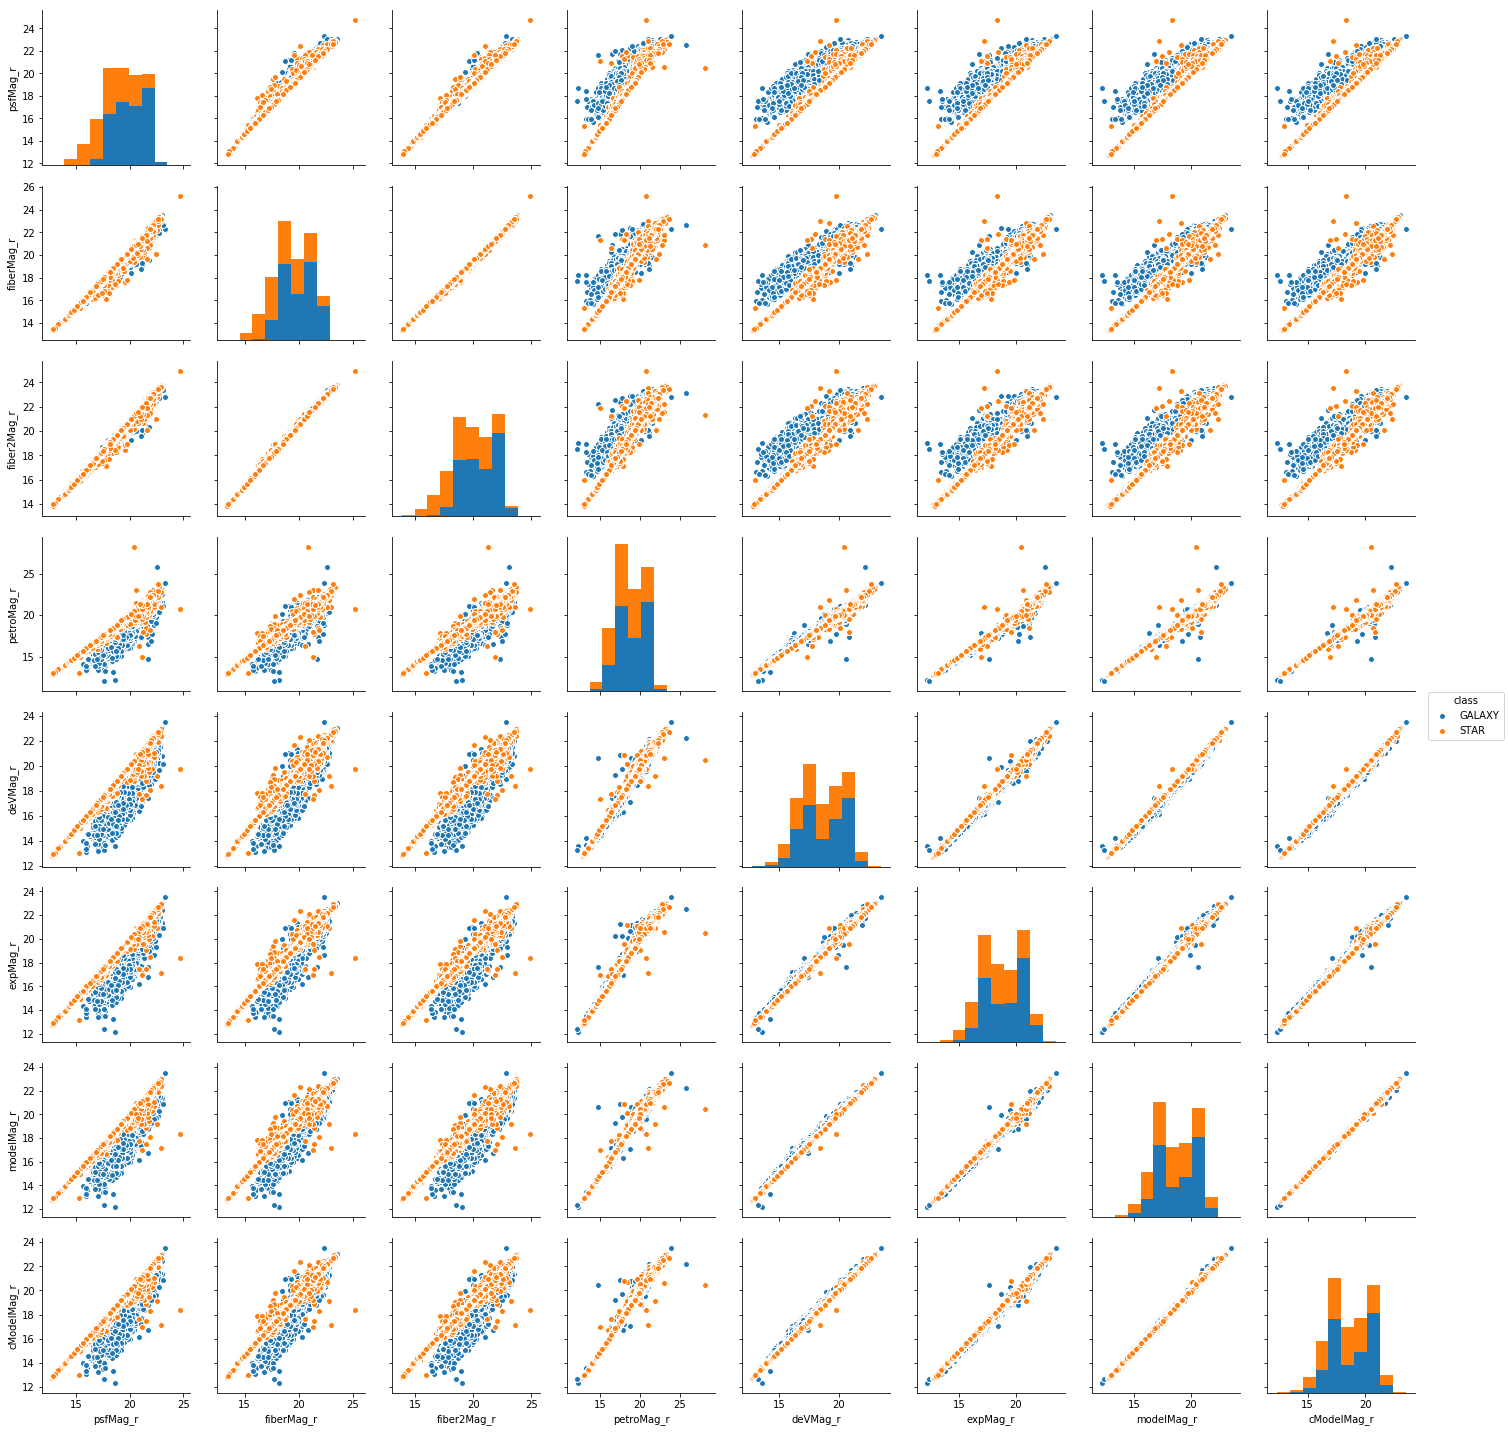

In [11]:
sdss_df = pd.read_hdf("sdss_training_set.h5")
sns.pairplot(sdss_df, hue = 'class', diag_kind = 'hist')

**Problem 1b**

Based on your plots of the data, which feature do you think will be the most important for separating stars and galaxies? Why? 

*write your answer here - do not change it after later completing the problem*

The final data preparation step it to create an independent test set to to evalute the generalization error of the final tuned model. Independent test sets are generated by witholding a fraction of the training set. No hard and fast rules apply for the fraction to be withheld, though typical choices vary between $\sim{0.2}-0.5$.

[`sklearn.model_selection`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) has a useful helper function [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

**Problem 1c** Split the 20k spectroscopic sources 70-30 into training and test sets. Save the results in arrays called: `train_X, train_y, test_X, test_y`, respectively. Use `rs` for the `random_state` in `train_test_split`.

*Hint - recall that `sklearn` utilizes X, a 2D `np.array()`, and y as the features and labels arrays, respecitively.*

In [13]:
from sklearn.model_selection import train_test_split
rs = 1851

feats = list(sdss_df.columns)
feats.remove('class')

X = np.array(sdss_df[feats])
y = np.array(sdss_df['class'])

train_X, test_X, train_y, test_y = train_test_split( X, y, test_size = 0.3, random_state = rs)

We will now ignore everything in the test set until we have fully optimized the machine learning model.

## Problem 2) Model Building

After curating the data, you must select a specific machine learning algorithm. With experience, it is possible to develop intuition for the best ML algorithm given a specific problem.

Short of that? Try two (or three, or four, or five) different models and choose whichever works the best.

**Problem 2a**

Train a $k$-nearest neighbors model on the star-galaxy training set. Select $k$ = 25 for this model.

*Hint* - the [`KNeighborsClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) object in the [`sklearn.neighbors`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) module may be useful for this task.

In [78]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=25)
knn_clf.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=25, p=2,
           weights='uniform')

**Problem 2b**

Train a Random Forest (RF) model [(Breiman 2001)](http://link.springer.com/article/10.1023/A:1010933404324) on the training set. Include 50 trees in the forest using the `n_estimators` parameter. Again, set `random_state` = rs.

*Hint* - use the [`RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) object from the [`sklearn.ensemble`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble) module. Also - be sure to set `n_jobs = -1` in every call of `RandomForestClassifier`.

In [79]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=50, random_state=rs, n_jobs=-1)
rf_clf.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=1851,
            verbose=0, warm_start=False)

A nice property of RF, relative to $k$NN, is that RF naturally provides an estimate of the most important features in a model.

RF feature importance is measured by randomly shuffling the values of a particular feature, and measuring the decrease in the model's overall accuracy. The relative feature importances can be accessed using the `.feature_importances_` attribute associated with the `RandomForestClassifer()` object. The higher the value, the more important feature. 

**Problem 2c**

Calculate the relative importance of each feature. 

Which feature is most important? Does this match your answer from **1c**?

In [60]:
feat_str = ',\n'.join(['{}'.format(feat) for feat in np.array(feats)[np.argsort(rf_clf.feature_importances_)[::-1]]])

print('From most to least important: \n{}'.format(feat_str))

From most to least important: 
psfMag_r,
fiber2Mag_r,
deVMag_r,
fiberMag_r,
petroMag_r,
modelMag_r,
cModelMag_r,
expMag_r


*write your answer here*

## Problem 3) Model Evaluation

To evaluate the performance of the model we establish a baseline (or figure of merit) that we would like to exceed. For our current application we want to maximize the accuracy of the model.

If the model does not improve upon the baseline (or reach the desired figure of merit) then one must iterate on previous steps (feature engineering, algorithm selection, etc) to accomplish the desired goal.

The SDSS photometric pipeline uses a simple parametric model to classify sources as either stars or galaxies. If we are going to the trouble of building a complex ML model, then it stands to reason that its performance should exceed that of the simple model. Thus, we adopt the SDSS photometric classifier as our baseline.

The SDSS photometric classifier uses a [single hard cut](http://www.sdss.org/dr12/algorithms/classify/#photo_class) to separate stars and galaxies in imaging data:

$$\mathtt{psfMag_r} - \mathtt{cModelMag_r} > 0.145.$$

Sources that satisfy this criteria are considered galaxies. 

**Problem 3a** 

Determine the baseline figure of merit by measuring the accuracy of the SDSS photometric classifier on the training set. 

*Hint - the [`accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function in the [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) module may be useful.*

In [41]:
from sklearn.metrics import accuracy_score

phot_y = np.empty_like(train_y)
phot_gal = np.logical_not(train_X[:,0] - train_X[:,-1] < 0.145)
phot_y[phot_gal] = 'GALAXY'
phot_y[~phot_gal] = 'STAR'

print("The baseline FoM = {:.4f}".format(accuracy_score(train_y, phot_y)))

The baseline FoM = 0.9672


**Problem 3b**

Use 10-fold cross validation to estimate the FoM for the $k$NN model. Take the mean value across all folds as the FoM estimate.

*Hint* - the [`cross_val_score`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function from the `sklearn.model_selection` module performs the necessary calculations.

In [58]:
from sklearn.model_selection import cross_val_score

knn_cv = cross_val_score(knn_clf, train_X, train_y, cv=10)

print('The kNN model FoM = {:.4f} +/- {:.4f}'.format(np.mean(knn_cv), np.std(knn_cv, ddof=1)))

The kNN model FoM = 0.9707 +/- 0.0031


**Problem 3c**

Use 10-fold cross validation to estimate the FoM for the random forest model.

In [59]:
rf_cv = cross_val_score(rf_clf, train_X, train_y, cv=10)

print('The RF model FoM = {:.4f} +/- {:.4f}'.format(np.mean(rf_cv), np.std(rf_cv, ddof=1)))

The RF model FoM = 0.9714 +/- 0.0026


**Problem 3d**

Do the machine-learning models outperform the SDSS photometric classifier?

*write your answer here*

## Problem 4) Model Optimization

While the "off-the-shelf" model provides an improvement over the SDSS photometric classifier, we can further refine and improve the performance of the machine learning model by adjusting the model tuning parameters. A process known as model optimization.

All machine-learning models have tuning parameters. In brief, these parameters capture the smoothness of the model in the multidimentional-feature space. Whether the model is smooth or coarse is application dependent -- be weary of over-fitting or under-fitting the data. Generally speaking, RF (and most tree-based methods) have 3 flavors of tuning parameter:

1. $N_\mathrm{tree}$ - the number of trees in the forest `n_estimators` (default: 10) in `sklearn`
2. $m_\mathrm{try}$ - the number of (random) features to explore as splitting criteria at each node `max_features` (default: `sqrt(n_features)`) in `sklearn`
3. Pruning criteria - defined stopping criteria for ending continued growth of the tree, there are [many choices](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for this in `sklearn` (My preference is `min_samples_leaf` (default: 1) which sets the minimum number of sources allowed in a terminal node, or leaf, of the tree)

Just as we previously evaluated the model using CV, we must optimize the tuning paramters via CV. Until we "finalize" the model by fixing all the input parameters, we cannot evalute the accuracy of the model with the test set as that would be "snooping."

Before globally optimizing the model, let's develop some intuition for how the tuning parameters affect the final model predictions.

**Problem 4a**

Determine the 10-fold cross validation accuracy for RF models with $N_\mathrm{tree}$ = 1, 10, 100. 

How do you expect changing the number of trees to affect the results?

In [80]:
for ntree in [1,10,100]:
    rf_cv = cross_val_score(RandomForestClassifier(n_estimators=ntree), train_X, train_y, cv=10)

    print('With {:d} trees the FoM = {:.4f} +/- {:.4f}'.format(ntree, np.mean(rf_cv), np.std(rf_cv, ddof=1)))

With 1 trees the FoM = 0.9489 +/- 0.0046
With 10 trees the FoM = 0.9674 +/- 0.0043
With 100 trees the FoM = 0.9714 +/- 0.0026


*write your answer here*

Now we will optimize the model over all tuning parameters. How does one actually determine the optimal set of tuning parameters? Brute force.

We will optimize the model via a grid search that performs CV at each point in the 3D grid. The final model will adopt the point with the highest accuracy.

It is important to remember two general rules of thumb: (i) if the model is optimized at the edge of the grid, refit a new grid centered on that point, and (ii) the results should be stable in the vicinity of the grid maximum. If this is not the case the model is likely overfit.

**Problem 4b** 

Use [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to perform a **3-fold** CV grid search to optimize the RF star-galaxy model. Remember the rules of thumb. 

What are the optimal tuning parameters for the model?

*Hint 1 - think about the computational runtime based on the number of points in the grid. Do not start with a very dense or large grid.*

*Hint 2 - if the runtime is long, don't repeat the grid search even if the optimal model is on an edge of the grid*

In [82]:
from sklearn.model_selection import GridSearchCV

grid_results = GridSearchCV(RandomForestClassifier(n_jobs=-1), 
                            {'n_estimators': [30, 100, 300], 
                             'max_features': [1, 3, 7], 
                             'min_samples_leaf': [1,10,30]},
                            cv = 3)
grid_results.fit(train_X, train_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [30, 100, 300], 'max_features': [1, 3, 7], 'min_samples_leaf': [1, 10, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [89]:
print('The best model has {}'.format(grid_results.best_params_))

The best model has {'max_features': 7, 'min_samples_leaf': 10, 'n_estimators': 300}


Now that the model is fully optimized, you are ready for the moment of truth!

## Problem 5) Model Predictions

**Problem 5a** 

Calculate the FoM for the SDSS photometric model on the test set. 

In [90]:
phot_y = np.empty_like(test_y)
phot_gal = np.logical_not(test_X[:,0] - test_X[:,-1] < 0.145)
phot_y[phot_gal] = 'GALAXY'
phot_y[~phot_gal] = 'STAR'

print("The baseline FoM = {:.4f}".format(accuracy_score(test_y, phot_y)))

The baseline FoM = 0.9615


**Problem 5b**

Using the optimized model parameters from **4b** calculate the FoM for the random forest model.

*Hint* - remember that the model should be trained on the training set, but the predictions are for the test set.

In [93]:
rf_clf = RandomForestClassifier(max_features=7, min_samples_leaf=10, n_estimators=300, n_jobs=-1)
rf_clf.fit(train_X, train_y)
test_preds = rf_clf.predict(test_X)

print("The RF model has FoM = {:.4f}".format(accuracy_score(test_y, test_preds)))

The RF model has FoM = 0.9665


**Problem 5c**

Calculate the confusion matrix for the test set. Is there symmetry to the misclassifications?

*Hint* - the [`confusion_matrix`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function in `sklearn.metrics` will help.

In [95]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(test_y, test_preds))

[[3317  116]
 [  85 2482]]


*write your answer here*

**Problem 5d**

Calculate (and plot the region of interest) the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) assumming that stars are the positive class. 

*Hint 1* - you will need to calculate probabilistic classifications for the test set using the [`predict_proba()`](http://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba) method.

*Hint 2* - the [`roc_curve`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) function in the `sklearn.metrics` module will be useful.

(0.3, 1)

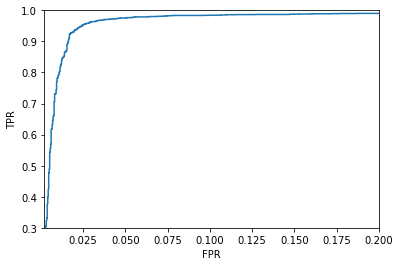

In [120]:
from sklearn.metrics import roc_curve

test_y_int = np.ones_like(test_y, dtype=int)
test_y_int[np.where(test_y == 'GALAXY')] = 0

test_preds_proba = rf_clf.predict_proba(test_X)

fpr, tpr, thresh = roc_curve(test_y_int, test_preds_proba[:,1])

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_xlim(2e-3,.2)
ax.set_ylim(0.3,1)

**Problem 5e**

Using the [`cross_val_predict`](http://scikit-learn.org/dev/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict) method in `sklearn.model_selection` determine cross-validated (10-fold) probabilistic estimates for each of the sources in the training set. With these CV estimates, calculate the resulting ROC curve and compare it to the ROC curve for the training set. 

Which method provides a better ROC curve? Why might this be the case?

*Hint* - you will want to set `method=’predict_proba’` in `cross_val_predict`.

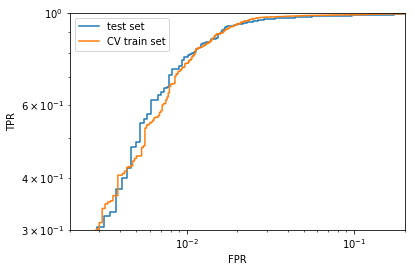

In [116]:
from sklearn.model_selection import cross_val_predict

train_y_int = np.ones_like(train_y, dtype=int)
train_y_int[np.where(train_y == 'GALAXY')] = 0

cv_preds_proba = cross_val_predict(rf_clf, train_X, train_y_int, cv=10, method='predict_proba')

cv_fpr, cv_tpr, cv_thresh = roc_curve(train_y_int, cv_preds_proba[:,1])

fig, ax = plt.subplots()
ax.plot(fpr, tpr, label = 'test set')
ax.plot(cv_fpr, cv_tpr, label = 'CV train set')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_xlim(2e-3,.2)
ax.set_ylim(0.3,1)
ax.legend()

*write your answer here*

**Problem 5f**

Suppose that (like me) you really care about supernovae. In this case you want a model that correctly classifies 99% of all stars, so that stellar flares do not fool you into thinking you have found a new supernova.

What classification threshold should be adopted for this model?

What fraction of galaxies does this model misclassify?

In [124]:
tpr_99_thresh = thresh[np.argmin(np.abs(0.99 - tpr))]

print('This model requires a classification threshold of {:.4f}'.format(tpr_99_thresh))

fpr_at_tpr_99 = fpr[np.argmin(np.abs(0.99 - tpr))]

print('This model misclassifies {:.2f}% of galaxies'.format(fpr_at_tpr_99*100))

This model requires a classification threshold of 0.0421
This model misclassifies 17.62% of galaxies


## Problem 6) Classify New Data

Run the cell below to load in some new data (which in this case happens to have known labels, but in practice this will almost never be the case...)

In [138]:
new_data_df = pd.read_hdf("blind_test_set.h5")

**Problem 6a**

Create a feature and label array for the new data. 

*Hint* - copy the code you developed above in Problem 2.

In [139]:
new_X = np.array(new_data_df[feats])
new_y = np.array(new_data_df['class'])

**Problem 6b**

Calculate the accuracy of the model predictions on the new data.

In [140]:
new_preds = rf_clf.predict(new_X)
print("The model has an accuracy of {:.4f}".format(accuracy_score(new_y, new_preds)))

The model has an accuracy of 0.7761


### Bonus Credit

**Problem 6c**

Can you explain why the accuracy for the new data is significantly lower than what you calculated previously? 

[If you can build and train a better model (using the trianing data) for classifying the new data **LOTS** of extra credit will be awarded]

*write your answer here*